In [86]:
from funciones_helmholtz import *
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
# reload kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
L = 1.0            # Longitud del lado del cuadrado
n_per_side = 50    # Número de elementos por lado
h = L / n_per_side # Tamaño de los elementos
k = 2.0 * np.pi / L # Número de onda
print(f"n_per_side = {n_per_side}, h = {h}, k = {k}")

# Coordenadas de nodos por lado
# Lado inferior (p2 = 0)
bottom = np.array([[i*h, 0.0] for i in range(n_per_side)])
# Lado derecho (p1 = L)
right = np.array([[L, i*h] for i in range(n_per_side)])
# Lado superior (p2 = L)
top = np.array([[L - i*h, L] for i in range(n_per_side)])
# Lado izquierdo (p1 = 0)
left = np.array([[0.0, L - i*h] for i in range(n_per_side)])

# Concatenar coordenadas en orden antihorario
coords = np.vstack([bottom, right, top, left])
n_nodes = coords.shape[0]

# Crear elementos (pares de nodos consecutivos)
elems = np.array([[i, (i + 1) % n_nodes] for i in range(n_nodes)])

# Inicializar arreglo de u_boundary (condiciones de Dirichlet en cada nodo) como valores complejos
u_boundary = np.zeros(n_nodes)

# Definir condiciones de frontera
for i, (x, y) in enumerate(coords):
    if np.isclose(x, 0.0):  # Lado izquierdo
        u_boundary[i] = np.cos(k*y) 
    elif np.isclose(y, 0.0):  # Lado inferior
        u_boundary[i] = np.cos(k*y)
    elif np.isclose(x, L):  # Lado derecho
        u_boundary[i] =   np.cos(k*y) 
    elif np.isclose(y, L):  # Lado superior
        u_boundary[i] =   np.cos(k*y) 

n_per_side = 50, h = 0.02, k = 6.283185307179586


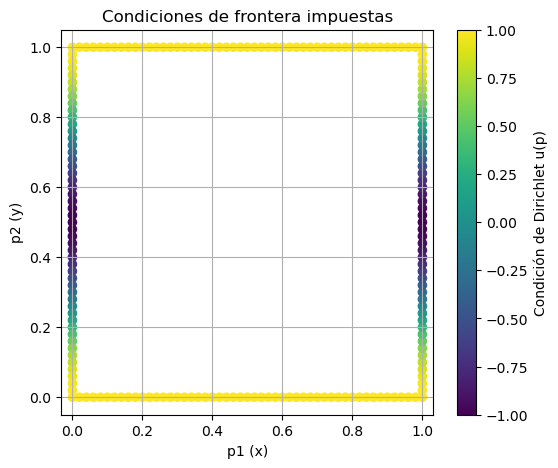

In [92]:
# Extraer coordenadas de los nodos
x_vals = coords[:, 0]
y_vals = coords[:, 1]

# Graficar u_boundary en función de la posición sobre la frontera
plt.figure(figsize=(6, 5))
sc = plt.scatter(x_vals, y_vals, c=u_boundary, cmap='viridis', s=35)
plt.colorbar(sc, label='Condición de Dirichlet u(p)')
plt.title("Condiciones de frontera impuestas")
plt.xlabel("p1 (x)")
plt.ylabel("p2 (y)")
plt.axis("equal")
plt.grid(True)
plt.show()

In [93]:
# Ensamblar matrices de influencia
Gmat, Hmat = assem(coords, elems, k)
q_boundary = solve(Gmat, Hmat.dot(u_boundary))

# Crear una malla regular de puntos internos
n_int = 150  # resolución de puntos internos por eje
x_vals = np.linspace(h, L - h, n_int)  # evitar la frontera
y_vals = np.linspace(h, L - h, n_int)
X, Y = np.meshgrid(x_vals, y_vals)
ev_coords = np.vstack([X.ravel(), Y.ravel()]).T  # shape: (n_points, 2)

# Evaluar solución en puntos internos
solution = eval_sol(ev_coords, coords, elems, u_boundary, q_boundary, k)

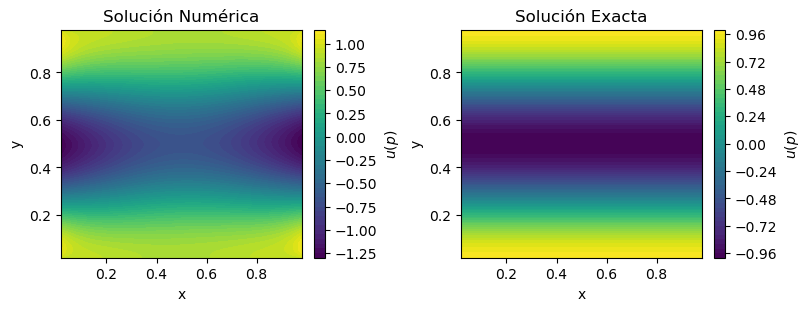

In [96]:
# Crear figura con dos subgráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

# Gráfico de la solución numérica
tcf1 = axs[0].tricontourf(ev_coords[:, 0], ev_coords[:, 1], np.real(solution), levels=50, cmap='viridis')
fig.colorbar(tcf1, ax=axs[0], label=r'$u(p)$')
axs[0].set_title("Solución Numérica")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Gráfico de la solución exacta
tcf2 = axs[1].tricontourf(ev_coords[:, 0], ev_coords[:, 1], np.cos(k * ev_coords[:, 1]), levels=50, cmap='viridis')
fig.colorbar(tcf2, ax=axs[1], label=r'$u(p)$')
axs[1].set_title("Solución Exacta")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

plt.show()